In [1]:
import pandas as pd
import numpy as np
import re
import cv2
from glob import glob
import difflib as dl
from skimage.transform import radon, rotate
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import imutils
import easyocr

import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/4.1.1/bin/tesseract'

### load metadata

In [2]:
meta = pd.read_csv('meta_data.csv')
meta.shape

(1839, 31)

In [3]:
meta.head()

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
0,14134_19700101194928245_BHA6172_1.xml,\n\t,14134,2,1970-01-01T15:49:28.245-0400,0,1,A,0,BHA6172,...,589.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,context/14134_19700101194928245_BHA6172_1_cont...,NaN,NaN
1,14135_19700101195631172_BMU2999_1.xml,\n\t,14135,2,1970-01-01T15:56:31.172-0400,0,1,A,0,BMU2999,...,283.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14135_19700101195631172_BMU2999_1_ir_...,context/14135_19700101195631172_BMU2999_1_cont...,NaN,NaN
2,14136_19700101195849178_PFF9889_1.xml,\n\t,14136,2,1970-01-01T15:58:49.178-0400,0,1,A,0,PFF9889,...,583.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14136_19700101195849178_PFF9889_1_ir_...,context/14136_19700101195849178_PFF9889_1_cont...,NaN,NaN
3,14137_19700101200204933_PTA2105_1.xml,\n\t,14137,2,1970-01-01T16:02:04.933-0400,0,1,A,0,PTA2105,...,727.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14137_19700101200204933_PTA2105_1_ir_...,context/14137_19700101200204933_PTA2105_1_cont...,NaN,NaN
4,14140_19700101200442871_CCD7351_1.xml,\n\t,14140,2,1970-01-01T16:04:42.871-0400,0,1,A,0,CCD7351,...,943.0,280.0,80.0,1280.0,1024.0,NaN,ir_patch/14140_19700101200442871_CCD7351_1_ir_...,context/14140_19700101200442871_CCD7351_1_cont...,NaN,NaN


### read the names of all images

In [4]:
filenames = glob("ir_patch/*.jpg")
print(len(filenames))

1821


In [5]:
image_names = pd.DataFrame(filenames, columns = ['image_name'])
image_names.head()

,image_name
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...


The number of entries in the metadata is greater than the number of images.

In [6]:
# merge image_names and meta_data to get the targets
plates = image_names.merge(meta,how='inner',left_on='image_name',right_on='IRImagePatch')
plates = plates[['image_name','VRN']]

In [7]:
# There are duplicated entries in metadata
# drop duplicates
plates.drop_duplicates(inplace=True)

In [8]:
plates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821 entries, 0 to 1838
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1821 non-null   object
 1   VRN         1821 non-null   object
dtypes: object(2)
memory usage: 42.7+ KB


In [9]:
plates.head()

,image_name,VRN
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368


In [10]:
# save the names of the images in a list
name_list = plates.image_name.tolist()

## cv2 + pytesseract

### try for a single image

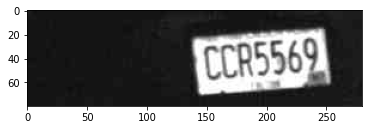

In [11]:
# read image
image = cv2.imread(name_list[1])
plt.imshow(image)

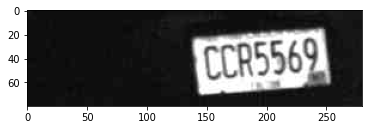

In [12]:
# convert to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap='gray')

In [13]:
grayscale_image

array([[34, 32, 29, ..., 28, 28, 28],
       [33, 31, 29, ..., 28, 28, 28],
       [31, 30, 28, ..., 28, 28, 28],
       ...,
       [20, 20, 20, ..., 28, 28, 28],
       [20, 20, 20, ..., 28, 28, 28],
       [20, 20, 20, ..., 28, 28, 28]], dtype=uint8)

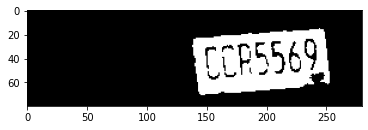

In [14]:
# threshold using OTSU method
thresh_value, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(threshold_image, cmap='gray')

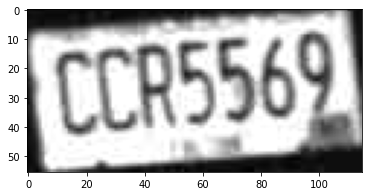

In [15]:
# get the largest contour and crop the image
contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
x, y, w, h = cv2.boundingRect(sorted_contours[0])
cropped_plate = grayscale_image[y:y+h, x:x+w]
plt.imshow(cropped_plate, cmap='gray')

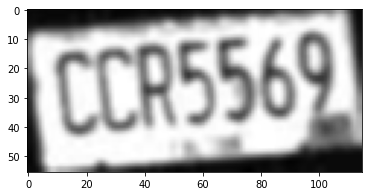

In [16]:
# blur
gaussian = cv2.GaussianBlur(cropped_plate, (3, 3), 50)
plt.imshow(gaussian, cmap='gray')

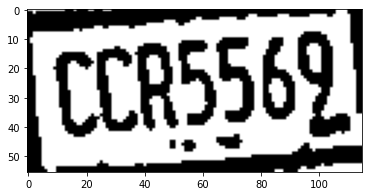

In [17]:
# threshold on the cropped image
thresh = cv2.adaptiveThreshold(gaussian,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,3)
plt.imshow(thresh, cmap='gray')

In [18]:
# extract text using tesseract
print(pytesseract.image_to_string(thresh, 
                                  config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))

CCR5569



### apply to all image

In [20]:
result = plates.copy()
for name in name_list:
    # load image
    image = cv2.imread(name)
    # grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # crop image
    thresh_value, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(sorted_contours[0])
    cropped_plate = grayscale_image[y:y+h, x:x+w]
    # blur
    gaussian = cv2.GaussianBlur(cropped_plate, (3, 3), 50)
    # threshold
    thresh = cv2.adaptiveThreshold(gaussian,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,3)
    # recognize by tesseract
    recognition = pytesseract.image_to_string(thresh, 
                            config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    recognition = recognition.strip()
    result.loc[plates['image_name']==name,'recognition'] = recognition

In [21]:
result.head()

,image_name,VRN,recognition
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,EBX797E
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PU8368


In [23]:
# save the recognitions as a csv file
result.to_csv('Recognition by tesseract.csv',index=False)

We have tried other threshold methods, adding morphology(erosion + dilation), rotation, different parameters for the blurring and thresholding. Above is the best we could get. 

In [ ]:
# in this example, we first cropped the images, then rotate it, and crop it again. We also performed normalization
# and morphology transformation to remove background. We saved the processed images and used Tesseract to recognize
# the plates. However, the result was not better than what we got with the previously mentioned method. 
for name in name_list:
    # load image
    image = cv2.imread(name)
    # crop image
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh_value, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(sorted_contours[0])
    cropped_plate_color = image[y:y+h, x:x+w]
    # rotate image
    cropped_plate = grayscale_image[y:y+h, x:x+w]
    zero_centered_image = cropped_plate - np.mean(cropped_plate)
    sinogram = radon(zero_centered_image, circle=False)
    rotation_angle = np.argmax(sum(abs(sinogram)))
    image_rotated_color = rotate(cropped_plate_color, -rotation_angle+90, resize=True, cval=0)
    # normailze image
    norm_image = cv2.normalize(image_rotated_color, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    # remove background
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    eroded = cv2.erode(norm_image,kernel)
    dilated = cv2.dilate(eroded, kernel)
    # crop image again
    thresh_value, threshold_image = cv2.threshold(dilated, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    grayscale_image2 = cv2.cvtColor(threshold_image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(grayscale_image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(sorted_contours[0])
    cropped_plate2 = dilated[y:y+h, x:x+w]
    # save image
    newname = 'processed/' + name
    plt.imsave(newname,cropped_plate2)

## try another library: easyocr

### try on one image

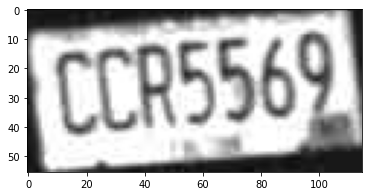

In [24]:
# read image
image = cv2.imread(name_list[1])

# convert to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold using OTSU method
thresh_value, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# crop image
contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
x, y, w, h = cv2.boundingRect(sorted_contours[0])
cropped_plate = image[y:y+h, x:x+w]
plt.imshow(cropped_plate, cmap='gray')

In [25]:
# extract text using easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext(image,detail = 0)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['CCR5569']

### apply to all image

In [26]:
result = plates.copy()
for name in name_list:
    # load image
    image = cv2.imread(name)
    # crop image
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh_value, threshold_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(sorted_contours[0])
    cropped_plate = image[y:y+h, x:x+w]
    # extract text
    reader = easyocr.Reader(['en'])
    recognition = reader.readtext(cropped_plate, detail = 0)
    # save the result
    if recognition != []:
        text = recognition[0]
        text = text.upper()
        text = re.sub('[^A-Za-z0-9]+', '', text)
        result.loc[plates['image_name']==name,'recognition'] = text

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

In [27]:
result.head()

,image_name,VRN,recognition
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,T539
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368


In [28]:
# save the result as a csv file.
result.to_csv('Recognitions by easyocr.csv',index=False)

## get the accuracy score for the result obtained by easyocr

In [96]:
# load the recognitions
df = pd.read_csv('Recognitions by easyocr.csv')

In [97]:
df.head()

,image_name,VRN,recognition
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   1821 non-null   object
 1   VRN          1821 non-null   object
 2   recognition  1813 non-null   object
dtypes: object(3)
memory usage: 42.8+ KB


In [99]:
df1 = df.copy()
# if it is an exact match, return True
df1['match'] = df1['VRN'] == df1['recognition']
# calculate the percentage of exact matches
df1.match.sum()/df1.shape[0]

0.3833058758923668

### calculate accuracy score for each plate: easyocr

In [100]:
# fill na with a space
df1.fillna(' ', inplace=True)

"difflib" has a function ratio() calculating the ratio of matches between two strings. However, for some reason, this function is not reliable. So we defined a function utilzing the get_matching_blocks() provided by this package.

In [101]:
# define a function to calculate accurary score
def get_accuracy(row):
    if row['recognition'] == ' ':
        accuracy = 0
    else:
        matches = dl.SequenceMatcher(None, row['VRN'], row['recognition']).get_matching_blocks()
        match_count = [x[-1] for x in matches]
        accuracy = sum(match_count)/len(row['VRN'])
    return accuracy

In [102]:
# calculate accuracy score for each plate
df1['accuracy'] = df1.apply(lambda row: get_accuracy(row),axis=1)

In [103]:
df1.head()

,image_name,VRN,recognition,match,accuracy
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797,True,1.0
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.0
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539,False,0.5
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426,True,1.0
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368,True,1.0


In [104]:
# statistics summary of the accurary
df1['accuracy'].describe()

count    1821.000000
mean        0.817381
std         0.223074
min         0.000000
25%         0.714286
50%         0.857143
75%         1.000000
max         1.000000
Name: accuracy, dtype: float64

In [105]:
# create a list of all character of the VRN.
df1['all_char'] = df1['VRN'].apply(lambda x:[char for char in x])

In [106]:
df1.head()

,image_name,VRN,recognition,match,accuracy,all_char
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797,True,1.0,"[C, B, X, 7, 9, 7]"
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.0,"[C, C, R, 5, 5, 6, 9]"
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539,False,0.5,"[A, T, 1, 5, 3, 9]"
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426,True,1.0,"[C, B, F, 4, 4, 2, 6]"
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368,True,1.0,"[P, V, Y, 8, 3, 6, 8]"


In [107]:
# define a function to get a list of the correctly recognized characters
def get_match_char(row):
    all_match_char = []
    matches = dl.SequenceMatcher(None, row['VRN'], row['recognition']).get_matching_blocks()
    VRN = row['VRN']
    mylist = [match for match in matches if match[-1]!=0]
    for match in mylist:
        start = match[0]
        stop = match[0] + match[2]
        match_str = VRN[start:stop]
        match_char = [char for char in match_str]
        all_match_char += match_char
    return all_match_char

In [108]:
# use the defined function to create a list of matching characters.
df1['match_char'] = df1.apply(lambda row: get_match_char(row), axis=1)

In [109]:
df1.head(10)

,image_name,VRN,recognition,match,accuracy,all_char,match_char
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797,True,1.000000,"[C, B, X, 7, 9, 7]","[C, B, X, 7, 9, 7]"
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.000000,"[C, C, R, 5, 5, 6, 9]","[C, C, R, 5, 5, 6, 9]"
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539,False,0.500000,"[A, T, 1, 5, 3, 9]","[5, 3, 9]"
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426,True,1.000000,"[C, B, F, 4, 4, 2, 6]","[C, B, F, 4, 4, 2, 6]"
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368,True,1.000000,"[P, V, Y, 8, 3, 6, 8]","[P, V, Y, 8, 3, 6, 8]"
5,ir_patch/16649_19700101184032831_PNA8367_1_ir_...,PNA8367,PNA8367,True,1.000000,"[P, N, A, 8, 3, 6, 7]","[P, N, A, 8, 3, 6, 7]"
6,ir_patch/14765_19700101131613659_PVM4381_1_ir_...,PVM4381,PVAJE,False,0.285714,"[P, V, M, 4, 3, 8, 1]","[P, V]"
7,ir_patch/14864_19700101172545117_PFE1103_1_ir_...,PFE1103,PFEL1O3,False,0.714286,"[P, F, E, 1, 1, 0, 3]","[P, F, E, 1, 3]"
8,ir_patch/14250_19700101120514185_PYL1367_1_ir_...,PYL1367,FYL136,False,0.714286,"[P, Y, L, 1, 3, 6, 7]","[Y, L, 1, 3, 6]"
9,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,BHA6172,BHA6172,True,1.000000,"[B, H, A, 6, 1, 7, 2]","[B, H, A, 6, 1, 7, 2]"


In [110]:
# define a function to get a list of the missed characters
def get_miss_char(row):
    all_char = row['all_char']
    match_char = row['match_char']
    miss_char = [char for char in all_char if char not in match_char]
    return miss_char

In [111]:
# create a list of missing characters.
df1['miss_char'] = df1.apply(lambda row: get_miss_char(row), axis=1)

In [112]:
df1.head(10)

,image_name,VRN,recognition,match,accuracy,all_char,match_char,miss_char
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797,True,1.000000,"[C, B, X, 7, 9, 7]","[C, B, X, 7, 9, 7]",[]
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.000000,"[C, C, R, 5, 5, 6, 9]","[C, C, R, 5, 5, 6, 9]",[]
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539,False,0.500000,"[A, T, 1, 5, 3, 9]","[5, 3, 9]","[A, T, 1]"
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426,True,1.000000,"[C, B, F, 4, 4, 2, 6]","[C, B, F, 4, 4, 2, 6]",[]
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368,True,1.000000,"[P, V, Y, 8, 3, 6, 8]","[P, V, Y, 8, 3, 6, 8]",[]
5,ir_patch/16649_19700101184032831_PNA8367_1_ir_...,PNA8367,PNA8367,True,1.000000,"[P, N, A, 8, 3, 6, 7]","[P, N, A, 8, 3, 6, 7]",[]
6,ir_patch/14765_19700101131613659_PVM4381_1_ir_...,PVM4381,PVAJE,False,0.285714,"[P, V, M, 4, 3, 8, 1]","[P, V]","[M, 4, 3, 8, 1]"
7,ir_patch/14864_19700101172545117_PFE1103_1_ir_...,PFE1103,PFEL1O3,False,0.714286,"[P, F, E, 1, 1, 0, 3]","[P, F, E, 1, 3]",[0]
8,ir_patch/14250_19700101120514185_PYL1367_1_ir_...,PYL1367,FYL136,False,0.714286,"[P, Y, L, 1, 3, 6, 7]","[Y, L, 1, 3, 6]","[P, 7]"
9,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,BHA6172,BHA6172,True,1.000000,"[B, H, A, 6, 1, 7, 2]","[B, H, A, 6, 1, 7, 2]",[]


In [113]:
# combine all matched characters
all_matches = []
for i in range(df1.shape[0]):
    all_matches += df1.iloc[i, 6]

In [114]:
# count the matched charaters and sort
for count, char in sorted(((all_matches.count(char), char) for char in set(all_matches)), reverse=True):
    print(f'count of {char}: {count}')

count of P: 725
count of 3: 677
count of 6: 656
count of 9: 626
count of 4: 624
count of 5: 619
count of 2: 596
count of 8: 582
count of C: 568
count of 7: 564
count of B: 500
count of 1: 432
count of 0: 413
count of A: 294
count of D: 174
count of F: 144
count of J: 141
count of G: 138
count of L: 137
count of H: 130
count of E: 127
count of T: 122
count of Z: 120
count of V: 117
count of N: 107
count of K: 107
count of U: 106
count of I: 104
count of Y: 96
count of S: 96
count of R: 86
count of X: 79
count of W: 49
count of Q: 25
count of M: 15
count of O: 6


In [115]:
# combine all missed characters
all_misses = []
for i in range(df1.shape[0]):
    all_misses += df1.iloc[i, 7]

# count the missed charaters and sort
for count, char in sorted(((all_misses.count(char), char) for char in set(all_misses)), reverse=True):
    print(f'count of {char}: {count}') 

count of 1: 230
count of 0: 203
count of A: 147
count of W: 130
count of M: 128
count of 2: 115
count of 8: 89
count of 3: 84
count of B: 82
count of D: 64
count of 7: 63
count of 4: 62
count of Q: 55
count of N: 44
count of Y: 43
count of 6: 43
count of G: 42
count of T: 41
count of 9: 39
count of 5: 35
count of S: 33
count of Z: 29
count of P: 27
count of I: 24
count of H: 24
count of F: 24
count of C: 20
count of K: 18
count of X: 16
count of R: 14
count of L: 13
count of J: 12
count of E: 11
count of V: 8
count of U: 7
count of O: 2
count of w: 1


<AxesSubplot:>

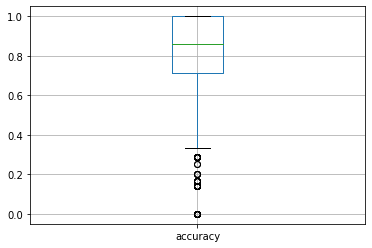

In [116]:
# boxplot of the accuracies
df1.boxplot(column=['accuracy'])

In [117]:
# label missing one matches
df1['miss_one'] = df1['miss_char'].map(lambda x: len(x)==1)

In [118]:
# ratio of missing one matches
df1['miss_one'].sum()/df1.shape[0]

0.28885227896760024

In [119]:
# calculate the ratio of exact matches plus missing-one-character matches
(df1['miss_one'].sum() + df1['match'].sum())/df1.shape[0]

0.6721581548599671

## get the accuracy score: tesseract

In [82]:
# load the recognitions
df = pd.read_csv('Recognitions by tesseract.csv')

In [83]:
df.head()

,image_name,VRN,recognition
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,EBX797E
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,NaN
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,NaN
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PU8368


In [84]:
df1 = df.copy()
# True if exact match otherwise False
df1['match'] = df1['VRN'] == df1['recognition']
# calculate the percentage of exact matches
df1.match.sum()/df1.shape[0]

0.053816584294343765

### calculate accuracy score for each plate

In [85]:
# fill na with a space
df1.fillna(' ', inplace=True)

In [86]:
# calculate accuracy score for each plate
df1['accuracy'] = df1.apply(lambda row: get_accuracy(row),axis=1)

In [87]:
df1.head()

,image_name,VRN,recognition,match,accuracy
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,EBX797E,False,0.833333
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.000000
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,,False,0.000000
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,,False,0.000000
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PU8368,False,0.714286


In [88]:
# a stastistics summary of accuracy
df1['accuracy'].describe()

count    1821.000000
mean        0.340478
std         0.371807
min         0.000000
25%         0.000000
50%         0.142857
75%         0.714286
max         1.000000
Name: accuracy, dtype: float64

In [89]:
# get a list of matching characters and miss-matching characters for each plate
df1['all_char'] = df1['VRN'].apply(lambda x:[char for char in x])

df1['match_char'] = df1.apply(lambda row: get_match_char(row), axis=1)

df1['miss_char'] = df1.apply(lambda row: get_miss_char(row), axis=1)

In [90]:
# combine all matched characters
all_matches = []
for i in range(df1.shape[0]):
    all_matches += df1.iloc[i, 6]

In [91]:
# count the matching charaters and sort
for count, char in sorted(((all_matches.count(char), char) for char in set(all_matches)), reverse=True):
    print(f'count of {char}: {count}')

count of 3: 358
count of P: 346
count of 2: 338
count of 6: 274
count of 0: 266
count of 9: 255
count of 8: 249
count of 5: 234
count of B: 231
count of 4: 209
count of C: 207
count of A: 172
count of 7: 160
count of 1: 136
count of L: 68
count of F: 61
count of E: 56
count of T: 53
count of H: 53
count of G: 51
count of Y: 49
count of R: 49
count of S: 46
count of K: 46
count of D: 46
count of U: 38
count of N: 28
count of J: 26
count of V: 25
count of Z: 24
count of I: 20
count of X: 17
count of W: 15
count of O: 2


In [92]:
# combine all missing characters
all_misses = []
for i in range(df1.shape[0]):
    all_misses += df1.iloc[i, 7]

# count the missing charaters and sort
for count, char in sorted(((all_misses.count(char), char) for char in set(all_misses)), reverse=True):
    print(f'count of {char}: {count}') 

count of 1: 543
count of 4: 478
count of 7: 470
count of 8: 425
count of 6: 415
count of 5: 412
count of 9: 408
count of 3: 408
count of P: 403
count of 2: 376
count of B: 351
count of C: 349
count of 0: 349
count of A: 269
count of D: 191
count of W: 164
count of M: 144
count of G: 131
count of J: 128
count of Z: 125
count of N: 123
count of T: 109
count of F: 109
count of I: 108
count of H: 101
count of V: 100
count of Y: 90
count of L: 84
count of S: 83
count of E: 83
count of Q: 82
count of K: 79
count of X: 78
count of U: 75
count of R: 53
count of O: 6
count of w: 1


<AxesSubplot:>

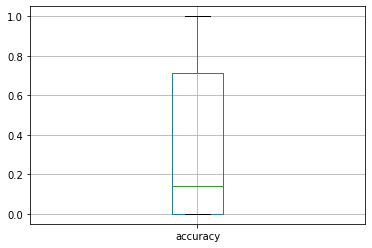

In [93]:
# boxlplot of the accuracy
df1.boxplot(column=['accuracy'])

In [94]:
# label the recognitions where there is only one miss-matching character
df1['miss_one'] = df1['miss_char'].map(lambda x: len(x)==1)
df1['miss_one'].sum()/df1.shape[0]

0.128500823723229

In [95]:
# calculate the percentage of exact match plus one miss-one-character match
(df1['miss_one'].sum() + df1['match'].sum())/df1.shape[0]

0.18231740801757276

### exploration

why "1" is the top missed character(EasyOCR)?

In [120]:
# label the recognitions where '1' was not correctly recognized.
df1['miss_1'] = df1['miss_char'].apply(lambda x: "1" in x)

In [121]:
# select these recognitions
temp = df1[df1['miss_1']==True]

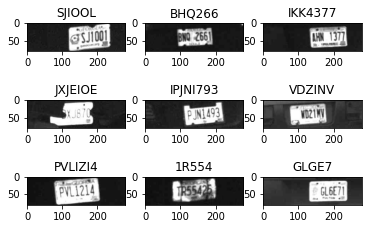

In [122]:
# display some of them
for i in range(9):
    plt.subplot(330+1+i)
    filename = temp.iloc[i+35,0]
    image = cv2.imread(filename)
    plt.imshow(image)
    plt.title(temp.iloc[i+35,2])
plt.show()

"1" is sometimes recognized as "I" or "L".

why "0" is the top missed character(EasyOCR)?

In [123]:
# label the recognitions where '0' was not correctly recognized.
df1['miss_0'] = df1['miss_char'].apply(lambda x: "0" in x)

In [124]:
# select these recognitions
temp = df1[df1['miss_0']==True]

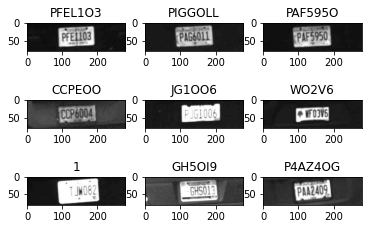

In [125]:
# display some of them
for i in range(9):
    plt.subplot(330+1+i)
    filename = temp.iloc[i,0]
    image = cv2.imread(filename)
    plt.imshow(image)
    plt.title(temp.iloc[i,2])
plt.show()

"0" is sometimes recognized as "O" .

In [126]:
# label the recognitions where 'A' was not correctly recognized.
df1['miss_A'] = df1['miss_char'].apply(lambda x: "A" in x)

In [127]:
# select these recognitions
temp = df1[df1['miss_A']==True]

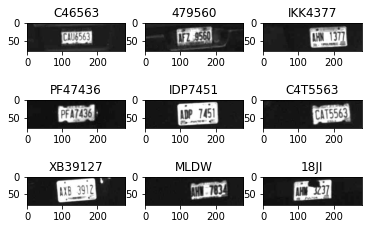

In [128]:
# show some of them
for i in range(9):
    plt.subplot(330+1+i)
    filename = temp.iloc[i+20,0]
    image = cv2.imread(filename)
    plt.imshow(image)
    plt.title(temp.iloc[i+20,2])
plt.show()

"A" is sometimes recognized as "4".

why no matches at all?

In [129]:
# label recognitions with no matches at all
df1['no_match'] = df1['match_char'].apply(lambda x: len(x)==0)

In [130]:
# select these recognitions
temp = df1[df1['no_match']==True]

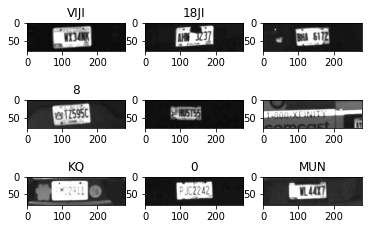

In [131]:
# show some of them
for i in range(9):
    plt.subplot(330+1+i)
    filename = temp.iloc[i+5,0]
    image = cv2.imread(filename)
    plt.imshow(image)
    plt.title(temp.iloc[i+5,2])
plt.show()

When the image is too bright, too dark, or the quality of the image is low, the recognition result is bad.

In [132]:
df1.head()

,image_name,VRN,recognition,match,accuracy,all_char,match_char,miss_char,miss_one,miss_1,miss_0,miss_A,no_match
0,ir_patch/14574_19700101213907739_CBX797_1_ir_p...,CBX797,CBX797,True,1.0,"[C, B, X, 7, 9, 7]","[C, B, X, 7, 9, 7]",[],False,False,False,False,False
1,ir_patch/14605_19700101004759437_CCR5569_1_ir_...,CCR5569,CCR5569,True,1.0,"[C, C, R, 5, 5, 6, 9]","[C, C, R, 5, 5, 6, 9]",[],False,False,False,False,False
2,ir_patch/14266_19700101121952907_AT1539_1_ir_p...,AT1539,539,False,0.5,"[A, T, 1, 5, 3, 9]","[5, 3, 9]","[A, T, 1]",False,True,False,True,False
3,ir_patch/14590_19700101221725855_CBF4426_1_ir_...,CBF4426,CBF4426,True,1.0,"[C, B, F, 4, 4, 2, 6]","[C, B, F, 4, 4, 2, 6]",[],False,False,False,False,False
4,ir_patch/16439_19700101122520938_PVY8368_1_ir_...,PVY8368,PVY8368,True,1.0,"[P, V, Y, 8, 3, 6, 8]","[P, V, Y, 8, 3, 6, 8]",[],False,False,False,False,False


In [133]:
# label the recognitions that are longer than the target.
df1['longer'] = df1.apply(lambda x: len(x['recognition'])>len(x['VRN']),axis=1)

In [134]:
df1.longer.sum()

148

In [135]:
# select these recognitions
temp = df1[df1['longer']==True]

In [136]:
temp.head(10)

,image_name,VRN,recognition,match,accuracy,all_char,match_char,miss_char,miss_one,miss_1,miss_0,miss_A,no_match,longer
51,ir_patch/16593_19700101160648812_DL9770B_1_ir_...,DL9770B,DL9770B1,False,1.000000,"[D, L, 9, 7, 7, 0, B]","[D, L, 9, 7, 7, 0, B]",[],False,False,False,False,False,True
69,ir_patch/14145_19700101203157953_AGV6998_1_ir_...,AGV6998,AGV69987,False,1.000000,"[A, G, V, 6, 9, 9, 8]","[A, G, V, 6, 9, 9, 8]",[],False,False,False,False,False,True
71,ir_patch/15885_19700101120555961_B3605_1_ir_pa...,B3605,BCC35051,False,0.800000,"[B, 3, 6, 0, 5]","[B, 3, 0, 5]",[6],True,False,False,False,False,True
75,ir_patch/16629_19700101175151211_43DH392_1_ir_...,43DH392,J430H392,False,0.857143,"[4, 3, D, H, 3, 9, 2]","[4, 3, H, 3, 9, 2]",[D],True,False,False,False,False,True
88,ir_patch/16167_19700101194622310_GT674I_1_ir_p...,GT674I,7616741,False,0.500000,"[G, T, 6, 7, 4, I]","[6, 7, 4]","[G, T, I]",False,False,False,False,False,True
90,ir_patch/15846_19700101112612578_BQ90DQ_1_ir_p...,BQ90DQ,BO9O091,False,0.500000,"[B, Q, 9, 0, D, Q]","[B, 9, 0]","[Q, D, Q]",False,False,False,False,False,True
94,ir_patch/16019_19700101135017886_PB2245_1_ir_p...,PB2245,PGB2245,False,1.000000,"[P, B, 2, 2, 4, 5]","[P, B, 2, 2, 4, 5]",[],False,False,False,False,False,True
123,ir_patch/15373_19700101124839030_CBU6551_1_ir_...,CBU6551,ICBU6554,False,0.857143,"[C, B, U, 6, 5, 5, 1]","[C, B, U, 6, 5, 5]",[1],True,True,False,False,False,True
135,ir_patch/15418_19700101132450686_CBU4_1_ir_pat...,CBU4,CBU33,False,0.750000,"[C, B, U, 4]","[C, B, U]",[4],True,False,False,False,False,True
140,ir_patch/15485_19700101160307863_BIF0207_1_ir_...,BIF0207,BIF02071,False,1.000000,"[B, I, F, 0, 2, 0, 7]","[B, I, F, 0, 2, 0, 7]",[],False,False,False,False,False,True


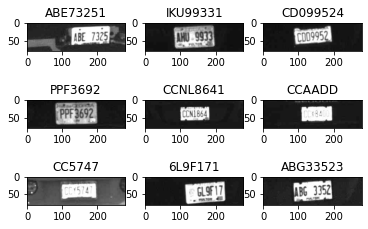

In [137]:
# show some of them
for i in range(9):
    plt.subplot(330+1+i)
    filename = temp.iloc[i+20,0]
    image = cv2.imread(filename)
    plt.imshow(image)
    plt.title(temp.iloc[i+20,2])
plt.show()

From these examples, we can see that EasyOCR tends to add "1" to the end of the recognitions. It probably because the edges are treated as a character. 